# GHONN pytorch models playground
place for testing the pytorch model

In [7]:
# Import libs

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from src import GHONN

## Create test data
Generate random sinus data for testing the HONN models.

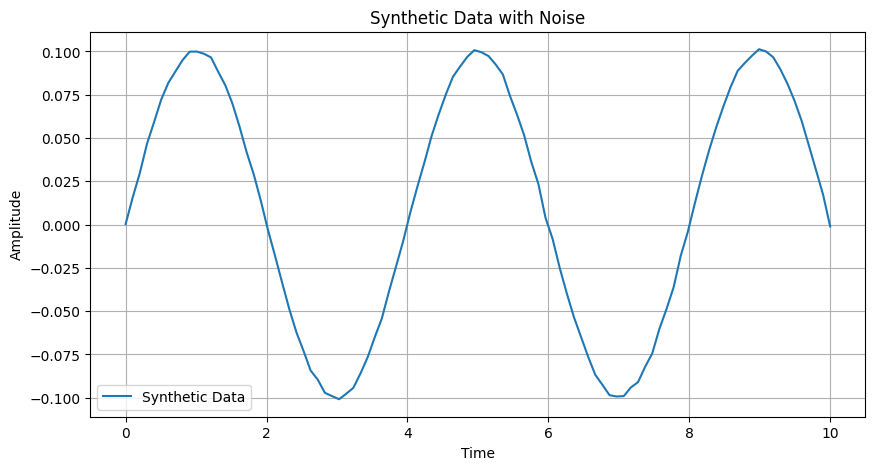

In [8]:
freqs = [0.25]
amps = [0.1, 0.2, 0.3]
phases = [0, 0.5, 1]
noise_lvl = 0.001
t_max = 10
n_samples = 100
t = np.linspace(0, t_max, n_samples)
# Generate synthetic data
signals = [
    amp * np.sin(2 * np.pi * freq * t + phase) for freq, amp, phase in zip(freqs, amps, phases)
]
noise = np.random.normal(0, noise_lvl, t.shape)
data = np.sum(signals, axis=0) + noise
# Plot the synthetic data
plt.figure(figsize=(10, 5))
plt.plot(t, data, label="Synthetic Data")
plt.title("Synthetic Data with Noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [9]:
# Prepare data for the models
N = data.shape[0]
prev_vals = 5  # Number of historical values to use
prediction_horizon = 1  # Predict two steps ahead

# Initialize X and y
X = np.zeros((N - prev_vals - prediction_horizon + 1, prev_vals))
y = np.zeros((N - prev_vals - prediction_horizon + 1, 1))

# Create historical values and targets
for i in range(prev_vals, N - prediction_horizon + 1):
    X[i - prev_vals] = data[i - prev_vals : i][::-1]  # Reverse to maintain chronological order
    y[i - prev_vals] = data[
        i + prediction_horizon - 1
    ]  # Target is `prediction_horizon` steps ahead

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Data shape: {data.shape}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
# Print the first 3 train/test pairs
print("First 3 training pairs:")
for i in range(3):
    print(f"X_train[{i}]: {X_train[i]}, y_train[{i}]: {y_train[i]}")

Data shape: (100,)
X_train shape: (76, 5), y_train shape: (76, 1)
X_test shape: (19, 5), y_test shape: (19, 1)
First 3 training pairs:
X_train[0]: [0.79196368 0.72974919 0.64671127 0.57703718 0.50038135], y_train[0]: [0.85607061]
X_train[1]: [0.85607061 0.79196368 0.72974919 0.64671127 0.57703718], y_train[1]: [0.9038469]
X_train[2]: [0.9038469  0.85607061 0.79196368 0.72974919 0.64671127], y_train[2]: [0.93647235]


In [10]:
# Train the HONU model
input_shape = X.shape[1]
output_shape = 1
layer_size = 4
predictor_orders = [2, 3]
gate_orders = [3, 2]
predictor_activations = ["identity"]
gate_activations = ["sigmoid", "tanh"]
output_type = "linear"
bias = True

lr_p = 0.01
lr_g = 0.001
batch_size = 10
epochs = 100

model = GHONN(
    input_shape,
    output_shape,
    layer_size,
    predictor_orders,
    gate_orders,
    predictor_activations=predictor_activations,
    gate_activations=gate_activations,
    output_type=output_type,
    bias=bias,
)

# Collect all predictor and gate parameters from each GHONU in the model
predictor_params = list(model.predictors.parameters())
gate_params = list(model.gates.parameters())

# Collect any other parameters not in predictors or gates (e.g., head)
all_params = set(model.parameters())
other_params = list(all_params - set(predictor_params) - set(gate_params))

optimizer = torch.optim.Adam(
    [
        {"params": predictor_params + other_params, "lr": lr_p},
        {"params": gate_params, "lr": lr_g},
    ]
)
loss_fn = torch.nn.MSELoss()

# Convert data to PyTorch tensors and add batch dimension
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Training loop
loss_history_train = np.zeros(epochs)  # To store average loss for each epoch
loss_history_test = np.zeros(epochs)  # To store average loss for each epoch
for epoch in tqdm(range(epochs), desc="Training Progress"):
    permutation = torch.randperm(X_train_tensor.size(0))
    epoch_loss = 0.0
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i : i + batch_size]
        input_batch, target_batch = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(input_batch)
        loss = loss_fn(outputs, target_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / (X_train_tensor.size(0) // batch_size)
    loss_history_train[epoch] = avg_loss  # Save the average loss for this epoch

    # Test the model on the test set
    epoch_loss_test = 0.0
    for i in range(0, X_test_tensor.size(0), batch_size):
        input_batch, target_batch = (
            X_test_tensor[i : i + batch_size],
            y_test_tensor[i : i + batch_size],
        )

        with torch.no_grad():
            outputs = model(input_batch)
            loss = loss_fn(outputs, target_batch)
            epoch_loss_test += loss.item()

    avg_loss_test = epoch_loss_test / (X_test_tensor.size(0) // batch_size)
    loss_history_test[epoch] = avg_loss_test  # Save the average loss for this epoch

# Print the achieved training loss
print(f"Achieved Training Loss: {loss_history_train[-1]:.6f}")
# Print the achieved testing loss
print(f"Achieved Testing Loss: {loss_history_test[-1]:.6f}")


Training Progress: 100%|██████████| 100/100 [00:01<00:00, 79.02it/s]

Achieved Training Loss: 0.000418
Achieved Testing Loss: 0.000419


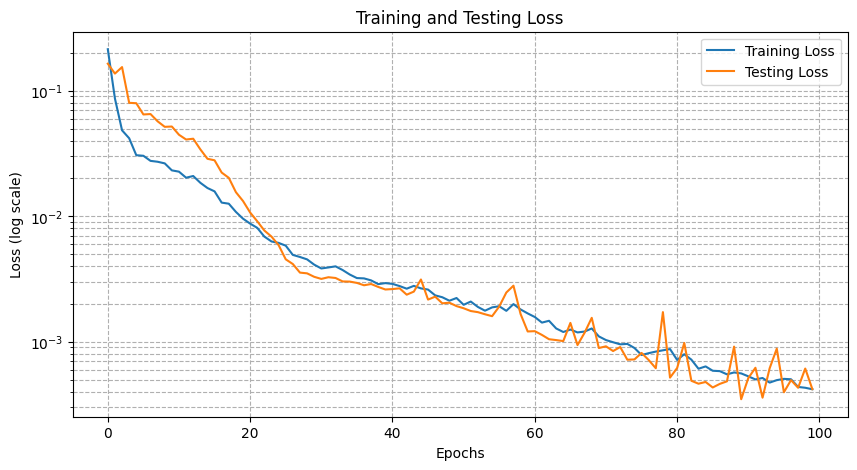

In [11]:
# Show training and testing loss on a log scale
plt.figure(figsize=(10, 5))
plt.plot(loss_history_train, label="Training Loss")
plt.plot(loss_history_test, label="Testing Loss")
plt.yscale("log")  # set y-axis to logarithmic scale
plt.title("Training and Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.grid(which="both", ls="--")
plt.show()

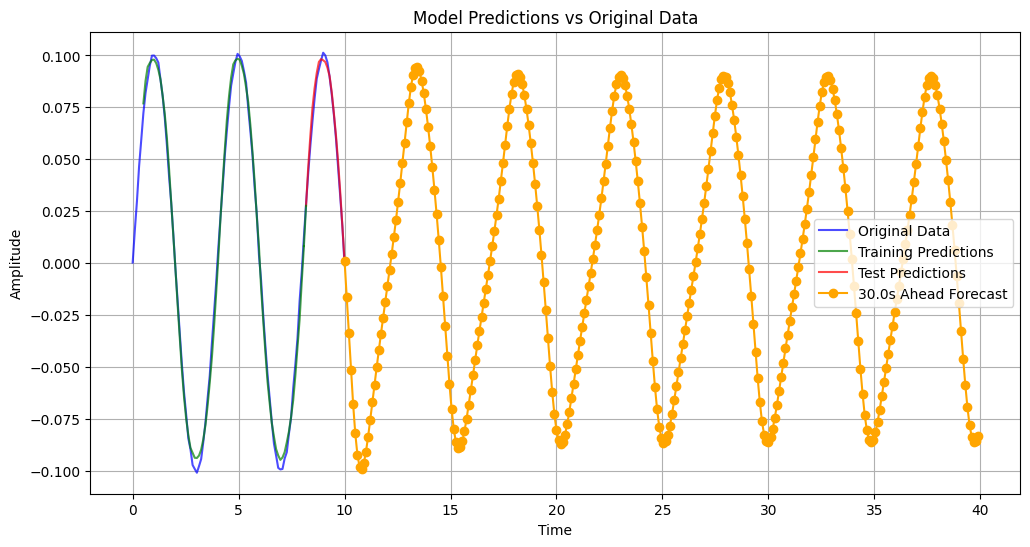

In [12]:
# Visualize model predictions
plt.figure(figsize=(12, 6))

# Original data
plt.plot(t, data, label="Original Data", color="blue", alpha=0.7)

# Model predictions on training data
train_predictions = model(X_train_tensor).detach().numpy()
train_predictions = scaler_y.inverse_transform(train_predictions)
# shift by prev_vals + (prediction_horizon - 1)
train_time = t[
    prev_vals + prediction_horizon - 1 : prev_vals + prediction_horizon - 1 + len(train_predictions)
]
plt.plot(train_time, train_predictions, label="Training Predictions", color="green", alpha=0.7)

# Model predictions on test data
test_predictions = model(X_test_tensor).detach().numpy()
test_predictions = scaler_y.inverse_transform(test_predictions)
# start after the end of train predictions, also shifted
test_time = t[
    prev_vals + prediction_horizon - 1 + len(train_predictions) : prev_vals
    + prediction_horizon
    - 1
    + len(train_predictions)
    + len(test_predictions)
]
plt.plot(test_time, test_predictions, label="Test Predictions", color="red", alpha=0.7)

# Connect last train point to first test point
if len(train_predictions) and len(test_predictions):
    plt.plot(
        [train_time[-1], test_time[0]],
        [train_predictions[-1], test_predictions[0]],
        color="green",
        alpha=0.7,
    )

# --- Multi‐step forecast beyond end of data (1 second ahead) ---
dt = t[1] - t[0]
t_ahead = 30.0
n_future = int(t_ahead / dt)

# start from last test‐window (normalized)
window = X_test_tensor[-1].clone().squeeze()
future_norm = []

model.eval()
with torch.no_grad():
    for _ in range(n_future):
        pred = model(window.unsqueeze(0)).squeeze()
        future_norm.append(pred.item())
        window = torch.cat([pred.unsqueeze(0), window[:-1]])

# back to original scale
future_preds = scaler_y.inverse_transform(np.array(future_norm).reshape(-1, 1)).flatten()

# build future time axis (exactly n_future steps)
future_times = test_time[-1] + np.arange(0, n_future) * dt


plt.plot(future_times, future_preds, color="orange", marker="o", label=f"{t_ahead}s Ahead Forecast")

# Plot settings
plt.title("Model Predictions vs Original Data")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [13]:
for name, param in model.named_parameters():
    print(name, param.size())

ghonus.0.predictor.weight torch.Size([21])
ghonus.0.gate.weight torch.Size([56])
ghonus.1.predictor.weight torch.Size([56])
ghonus.1.gate.weight torch.Size([21])
ghonus.2.predictor.weight torch.Size([21])
ghonus.2.gate.weight torch.Size([56])
ghonus.3.predictor.weight torch.Size([56])
ghonus.3.gate.weight torch.Size([21])
head.weight torch.Size([1, 4])
head.bias torch.Size([1])


In [14]:
print(model)

GHONN(
  in_features=5,
  out_features=1,
  layer_size=4,
  output_type=linear,
  predictor_activation_functions=('identity',),
  gate_activation_functions=('sigmoid', 'tanh'),
  head=Linear(in_features=4, out_features=1, bias=True),
  ghonus=ModuleList(
  (0): GHONU(
    in_features=5, 
    predictor=HONU(in_features=5, polynomial_order=2, bias=True, activation=identity),
    gate=HONU(in_features=5, polynomial_order=3, bias=True, activation=sigmoid)
  )
  (1): GHONU(
    in_features=5, 
    predictor=HONU(in_features=5, polynomial_order=3, bias=True, activation=identity),
    gate=HONU(in_features=5, polynomial_order=2, bias=True, activation=tanh)
  )
  (2): GHONU(
    in_features=5, 
    predictor=HONU(in_features=5, polynomial_order=2, bias=True, activation=identity),
    gate=HONU(in_features=5, polynomial_order=3, bias=True, activation=sigmoid)
  )
  (3): GHONU(
    in_features=5, 
    predictor=HONU(in_features=5, polynomial_order=3, bias=True, activation=identity),
    gate=HON

In [15]:
model.gates[0].weight

Parameter containing:
tensor([ 0.0685,  0.0094,  0.0025, -0.0114, -0.0108, -0.0132, -0.0223, -0.0233,
        -0.0276, -0.0240, -0.0160, -0.0212, -0.0212, -0.0161, -0.0189, -0.0163,
        -0.0154, -0.0143, -0.0129, -0.0034, -0.0016, -0.0419, -0.0319, -0.0299,
        -0.0303, -0.0225, -0.0259, -0.0223, -0.0189, -0.0116, -0.0209, -0.0136,
        -0.0102, -0.0109, -0.0044,  0.0039, -0.0255, -0.0203, -0.0143, -0.0092,
        -0.0148, -0.0102, -0.0073, -0.0070,  0.0036,  0.0014, -0.0064, -0.0082,
         0.0040, -0.0030,  0.0093,  0.0139,  0.0002,  0.0088,  0.0124,  0.0182],
       requires_grad=True)

In [16]:
model.ghonus[0].gate.weight

Parameter containing:
tensor([ 0.0685,  0.0094,  0.0025, -0.0114, -0.0108, -0.0132, -0.0223, -0.0233,
        -0.0276, -0.0240, -0.0160, -0.0212, -0.0212, -0.0161, -0.0189, -0.0163,
        -0.0154, -0.0143, -0.0129, -0.0034, -0.0016, -0.0419, -0.0319, -0.0299,
        -0.0303, -0.0225, -0.0259, -0.0223, -0.0189, -0.0116, -0.0209, -0.0136,
        -0.0102, -0.0109, -0.0044,  0.0039, -0.0255, -0.0203, -0.0143, -0.0092,
        -0.0148, -0.0102, -0.0073, -0.0070,  0.0036,  0.0014, -0.0064, -0.0082,
         0.0040, -0.0030,  0.0093,  0.0139,  0.0002,  0.0088,  0.0124,  0.0182],
       requires_grad=True)

In [17]:
model.gate_activations

('sigmoid', 'tanh', 'sigmoid', 'tanh')

In [18]:
print(list(model.parameters()))

[Parameter containing:
tensor([ 0.0256,  0.9122,  0.5981,  0.2446, -0.1174, -0.4856,  0.3579,  0.2676,
         0.1868,  0.1085,  0.0372,  0.1877,  0.1124,  0.0499, -0.0099,  0.0476,
        -0.0096, -0.0690, -0.0763, -0.1401, -0.2021], requires_grad=True), Parameter containing:
tensor([ 0.0685,  0.0094,  0.0025, -0.0114, -0.0108, -0.0132, -0.0223, -0.0233,
        -0.0276, -0.0240, -0.0160, -0.0212, -0.0212, -0.0161, -0.0189, -0.0163,
        -0.0154, -0.0143, -0.0129, -0.0034, -0.0016, -0.0419, -0.0319, -0.0299,
        -0.0303, -0.0225, -0.0259, -0.0223, -0.0189, -0.0116, -0.0209, -0.0136,
        -0.0102, -0.0109, -0.0044,  0.0039, -0.0255, -0.0203, -0.0143, -0.0092,
        -0.0148, -0.0102, -0.0073, -0.0070,  0.0036,  0.0014, -0.0064, -0.0082,
         0.0040, -0.0030,  0.0093,  0.0139,  0.0002,  0.0088,  0.0124,  0.0182],
       requires_grad=True), Parameter containing:
tensor([ 0.1821,  0.1608,  0.1139,  0.0786,  0.0288, -0.0025,  0.0983,  0.0781,
         0.0589,  0.0402,  0.

In [19]:
for name, param in model.named_parameters():
    print(name, param)

ghonus.0.predictor.weight Parameter containing:
tensor([ 0.0256,  0.9122,  0.5981,  0.2446, -0.1174, -0.4856,  0.3579,  0.2676,
         0.1868,  0.1085,  0.0372,  0.1877,  0.1124,  0.0499, -0.0099,  0.0476,
        -0.0096, -0.0690, -0.0763, -0.1401, -0.2021], requires_grad=True)
ghonus.0.gate.weight Parameter containing:
tensor([ 0.0685,  0.0094,  0.0025, -0.0114, -0.0108, -0.0132, -0.0223, -0.0233,
        -0.0276, -0.0240, -0.0160, -0.0212, -0.0212, -0.0161, -0.0189, -0.0163,
        -0.0154, -0.0143, -0.0129, -0.0034, -0.0016, -0.0419, -0.0319, -0.0299,
        -0.0303, -0.0225, -0.0259, -0.0223, -0.0189, -0.0116, -0.0209, -0.0136,
        -0.0102, -0.0109, -0.0044,  0.0039, -0.0255, -0.0203, -0.0143, -0.0092,
        -0.0148, -0.0102, -0.0073, -0.0070,  0.0036,  0.0014, -0.0064, -0.0082,
         0.0040, -0.0030,  0.0093,  0.0139,  0.0002,  0.0088,  0.0124,  0.0182],
       requires_grad=True)
ghonus.1.predictor.weight Parameter containing:
tensor([ 0.1821,  0.1608,  0.1139,  0.0